In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import sys
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sys.path.insert(0,"/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
import author
processed_engine = author.processed_engine
YEAR=365

In [2]:
btc_lasso, btc_ridge = [joblib.load(f"./only_btc/{n}") for n in ["Lasso_BTC_only.pkl","Ridge_BTC_only.pkl"]]
total_lasso, total_ridge = [joblib.load(f"total/v2/{n}") for n in ["Lasso_total.pkl","Ridge_total.pkl"]]


In [3]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d", processed_engine)
df.set_index(df.columns[0], inplace=True)
macd_gap = df['Macd_Signal'] - df['Macd']
X = df.drop(["Macd","Fast_k","Volume","Gap","Price"], axis=1)
X["Macd_Gap"] = macd_gap
X = X.iloc[:-1]
y = df['Price'].iloc[1:]


In [4]:
up_ratio = (X['Pct'] > 0).sum() / X.shape[0] #오른 날의 비율
down_ratio = 1 - up_ratio
print(f"up: {up_ratio}, down: {down_ratio}")

up: 0.5436190476190477, down: 0.45638095238095233


In [5]:
X

,Rsi,Macd_Signal,Vwap,Fast_d,Moment,Pct,Macd_Gap
time,,,,,,,
2015-02-28,58.802,2.738,240.599,17.051,0.916,0.171,2.104
2015-03-01,61.534,3.969,240.808,25.940,0.930,2.336,2.668
2015-03-02,67.566,6.123,241.435,30.447,0.965,5.945,3.858
2015-03-03,69.571,8.221,242.400,28.741,0.980,2.188,4.765
2015-03-04,63.536,9.085,243.084,22.262,0.964,-3.056,4.503
...,...,...,...,...,...,...,...
2022-05-03,38.879,-1081.377,27877.427,7.911,61.989,-2.022,-102.425
2022-05-04,48.366,-943.277,27887.285,17.622,61.846,5.160,28.540
2022-05-05,38.143,-1073.475,27897.073,16.616,61.371,-7.867,-81.326


In [6]:
lasso_only_predict = btc_lasso.predict(X)
ridge_only_predict = btc_ridge.predict(X)

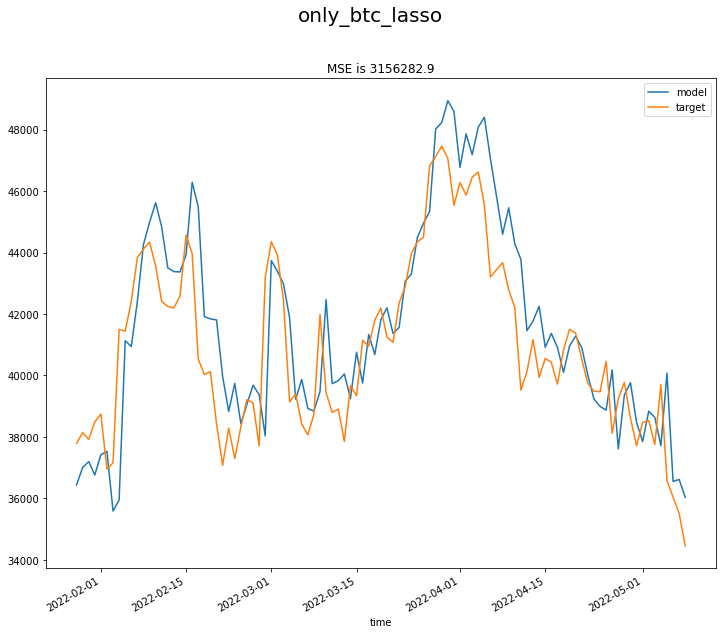

In [7]:
eval_model.visualize_plot(lasso_only_predict[-100:], y[-100:], name="only_btc_lasso")

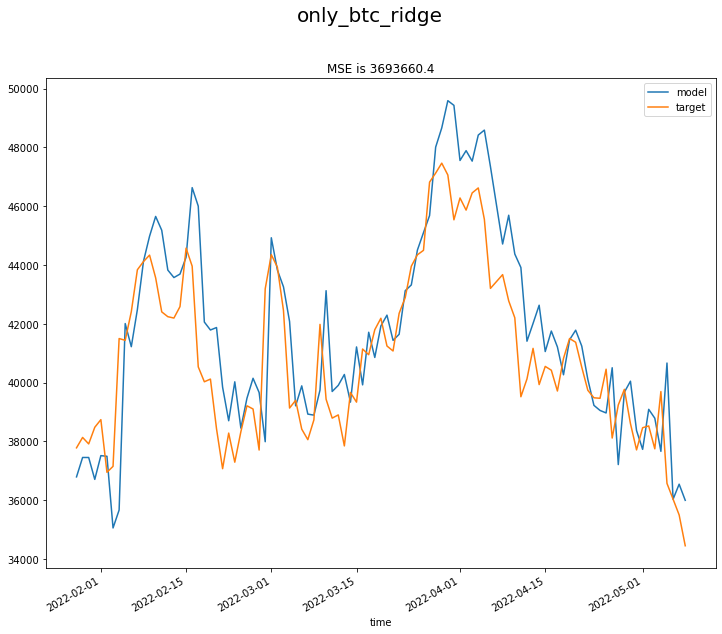

In [8]:
eval_model.visualize_plot(ridge_only_predict[-100:], y[-100:], name="only_btc_ridge")


비트코인 데이터로만 학습한 모델을 최적화 하자

In [9]:
def plot_bar(data, name):
    cnts = data.value_counts()
    cnts.sort_values(ascending=False,inplace=True)
    plt.figure(figsize=(12,8))
    plt.bar(cnts.index, cnts.values)
    plt.ylabel("Count")
    plt.xlabel("Error %")
    plt.xticks(range(-100,100,10))
    plt.title(name)
    plt.xlim(-100,100)

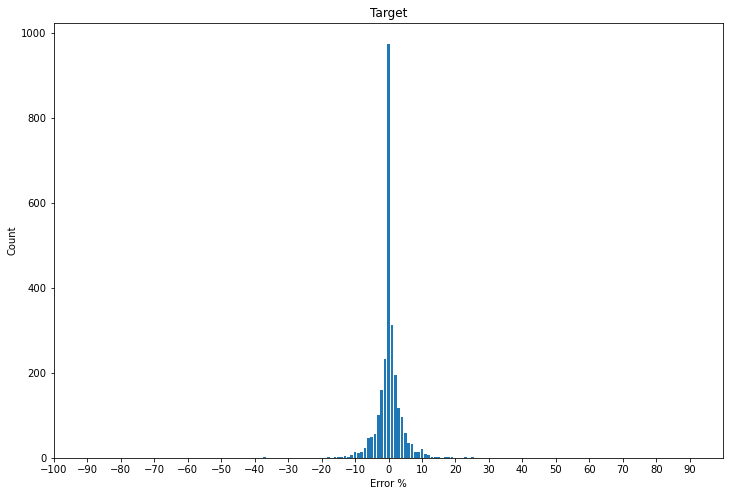

In [10]:
plot_bar(df['Pct'].astype(int), name="Target")

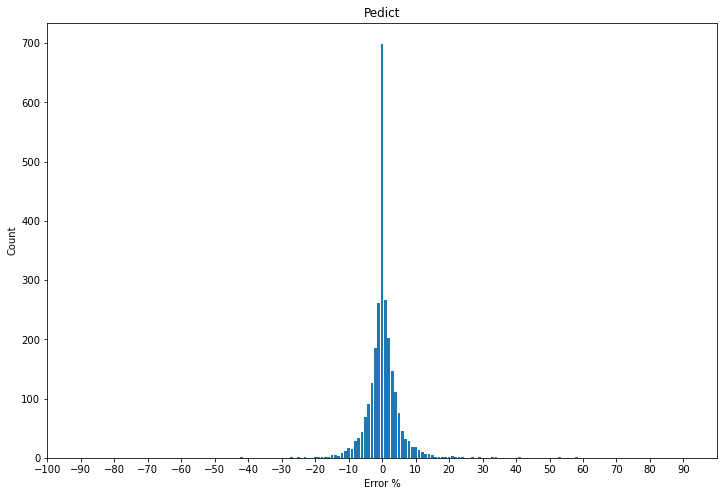

In [11]:
pred_pct = pd.Series(lasso_only_predict, index= X.index).pct_change().dropna() * 100
plot_bar(pred_pct.astype(int), name="Pedict")

var: 48.97045825222123, mean: -1.0962850822795873


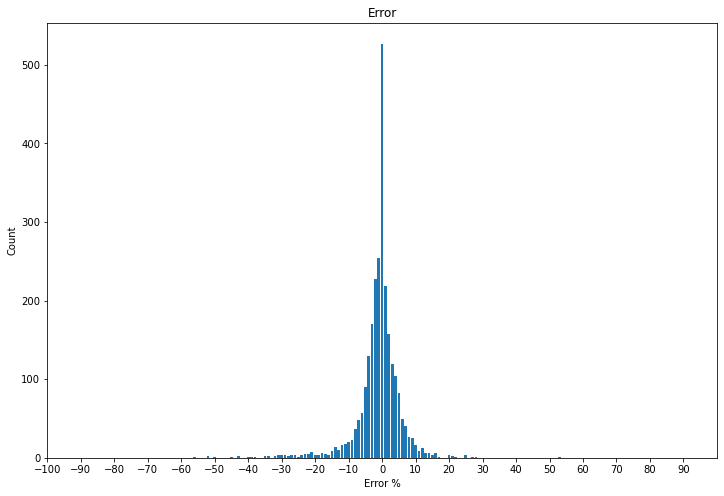

In [12]:
error = (lasso_only_predict - y) * 100 / y
error_mean = error.mean()
error_var = error.var()
error = error.astype(int)
print(f"var: {error_var}, mean: {error_mean}")
plot_bar(error,name="Error")


In [13]:
def get_thershold(pred_pct, X):
    for t in range(-5,5):
        pred_pct = pred_pct.round(2)
        price_pct = X['Pct'].iloc[1:] #다음날을 기준으로 비교해줘야 한다.
        true_pos = pred_pct[(pred_pct > t) & (price_pct > 0)] #모델이 상승세라 예측했고 실제로 상승한 날들
        false_pos = pred_pct[(pred_pct > t) & (price_pct <= 0)]
        true_neg = pred_pct[(pred_pct < t) & (price_pct < 0)]
        false_neg = pred_pct[(pred_pct < t) & (price_pct >= 0)]
        print("Threshold: ", t)
        print(f"true_pos: {len(true_pos)}, false_pos: {len(false_pos)}")
        print(f"true_neg: {len(true_neg)}, false_neg: {len(false_neg)}")
        precison = len(true_pos) / (len(true_pos) + len(false_pos))
        recall = len(true_pos) / (len(true_pos) + len(false_neg))
        f1 = (2 * precison * recall) / (precison + recall)
        print("Precision: ",precison)
        print("Recall: ",recall)
        print("F1: ", f1)

In [14]:
# (y - lasso_only_predict) * 100 / y 
# get_thershold(pred_pct, X)
get_thershold((lasso_only_predict - y) * 100 / y, X)


Threshold:  -5
true_pos: 1082, false_pos: 1121
true_neg: 77, false_neg: 343
Precision:  0.4911484339536995
Recall:  0.7592982456140351
F1:  0.5964718853362734
Threshold:  -4
true_pos: 972, false_pos: 1101
true_neg: 97, false_neg: 454
Precision:  0.46888567293777134
Recall:  0.6816269284712483
F1:  0.5555873106601886
Threshold:  -3
true_pos: 828, false_pos: 1075
true_neg: 123, false_neg: 598
Precision:  0.4351024697845507
Recall:  0.5806451612903226
F1:  0.49744668068489034
Threshold:  -2
true_pos: 653, false_pos: 1021
true_neg: 175, false_neg: 769
Precision:  0.3900836320191159
Recall:  0.45921237693389594
F1:  0.4218346253229974
Threshold:  -1
true_pos: 478, false_pos: 943
true_neg: 253, false_neg: 948
Precision:  0.33638282899366645
Recall:  0.33520336605890605
F1:  0.3357920618194591
Threshold:  0
true_pos: 324, false_pos: 836
true_neg: 357, false_neg: 1102
Precision:  0.2793103448275862
Recall:  0.22720897615708274
F1:  0.2505800464037123
Threshold:  1
true_pos: 201, false_pos: 691

In [33]:
def get_profit(pred_pct, y, thereshold, days=0): #현재로 부터 과거 몇일의 수익
    pred_pct = pred_pct.iloc[:-1]
    buy_point = pred_pct[pred_pct > thereshold] #예측 값이 전날의 예측 값 대비 i%이상 상승하면 매수
    buy_value = y.loc[y.index.isin(buy_point.index)]
    sell_point = [y.index.get_loc(i) + 1 for i in buy_value.index] #매수 다음 거래일에 바로 매도한다.
    sell_value = y.iloc[sell_point]

    profit = (sell_value.values - buy_value.values) / buy_value.values * 100
    seed = 1000 #처음 seed
    seed_record = [] #profit 저장용
    for p in profit[-days:]:
        seed = seed * (1 + (p / 100))
        seed_record.append(seed)
    return seed_record

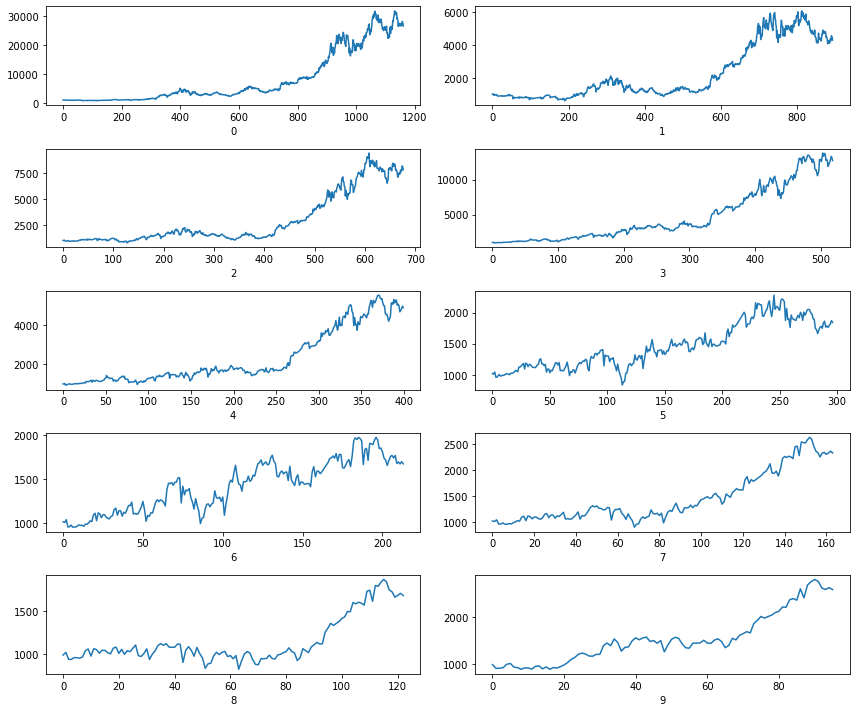

In [38]:
n_split = 10
rows = lambda x: x//2 if x % 2 == 0 else x//2 + 1
fig, axes = plt.subplots(rows(n_split), 2, figsize=(12,10))
for i in range(n_split):
    profit = get_profit((lasso_only_predict - y) * 100 / y, y, i)
    plt.subplot(rows(n_split), 2, i + 1)
    plt.plot(profit)
    plt.xlabel(i)
plt.tight_layout()

(18920.0, 19120.0)

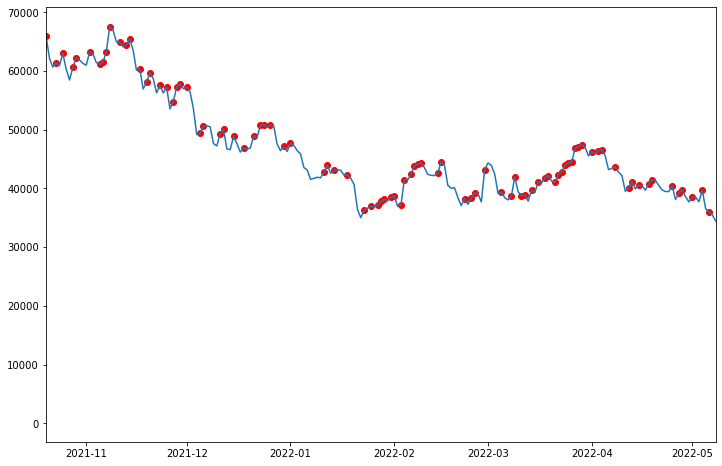

In [49]:
buy_point = pred_pct[pred_pct > 0] 
buy_value = y[buy_point.index]
plt.figure(figsize=(12,8))
plt.plot(y)
plt.scatter(x=buy_point.index, y = buy_value, c='r')
plt.xlim(df.index[-200],df.index[-1])


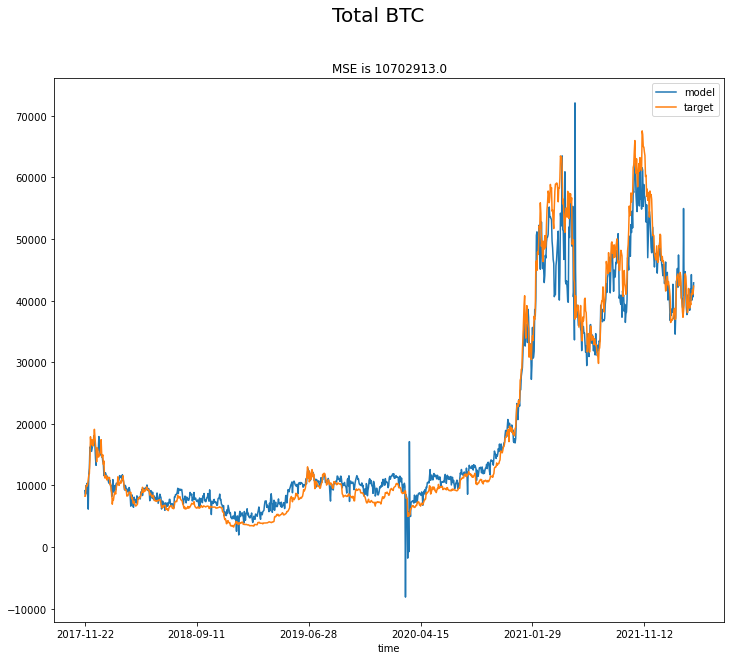

In [35]:
total_pred = [m.predict(total_X) for m in total_model]
total_res = total_pred[0] * 0.1 + total_pred[1] * 0.7 + total_pred[2] * 0.2
eval_model.visualize_plot(total_res, total_y, "Total BTC")


In [58]:
total_pct_pred = (total_res - total_y) / total_y * 100 #예측 값의 상승분

In [60]:
btc_pct_pred = pct_pred[pct_pred.index.isin(total_pct_pred.index)]

In [69]:
pct_df = pd.DataFrame(index=btc_pct_pred.index) #두 모델의 예측 값의 상승분을 저장한 df
pct_df['btc'] = btc_pct_pred.values
pct_df['total'] = total_pct_pred.values


(18589.0, 19088.0)

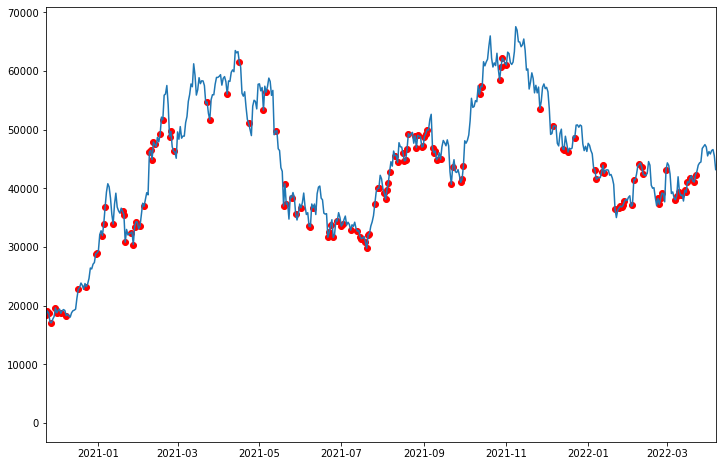

In [102]:
buy_point = pct_df[(pct_df['btc'] > 2) | (pct_df['total'] > 1)] #순수 비트 모델이 3%이상 오를 것이라고 예측한 날들 + 토탈 모델이 1% 이상 오른다고 예측한 날들
buy_value = btc_y[(btc_y.index).isin(buy_point.index)]
plt.figure(figsize=(12,8))
plt.plot(btc_y)
plt.scatter(x=buy_value.index, y = buy_value.values, c='r')
plt.xlim(df.index[-500],df.index[-1])


In [92]:
sell_dates = [btc_y.index.get_loc(i) + 1 for i in buy_value.index[:-1]] #매수 다음날 바로 매도한다.
profit = (btc_y.iloc[sell_dates] - buy_value.values[:-1]) / buy_value.values[:-1] * 100
seed = 1000 #처음 seed
result = [] #profit 저장용
for p in profit[-300:]: #약 지난 300일 간의 수익률
    seed = seed * (1 + (p / 100))
    result.append(seed)


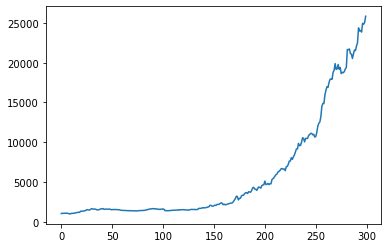

In [94]:
plt.plot(result)

In [95]:
total_profit = (result[-1] - result[0]) / result[0]
total_profit * 100

2419.667715646925